# Bayesian Optimization: Lasers Application

_Prepared by Ritz Aguilar for Thrill Summer School at Toulon, France, October 2024_

#### Objectives
- Differentiate the effects of using different utility/acquistion functions for BO.
- Use varying kernels for the Gaussian Process, e.g. Constant, Matern, RBF, etc.

### Exercise 1: Bayesian Optimization for Laser Stability

We will first simulate a laser system and optimize its stability by adjusting the pump strength $S_0$. The goal is to minimize fluctuations in the laser's output power due to noise and temperature sensitivity.

#### Problem Description
Given some target output power, we aim to find the best pump strength $S_0$ to minimize output power fluctuations. The power fluctuations are affected by:
- Pump strength $S_0$,
- Temperature $T$,
- Gaussian noise, simulating instability in the laser system or random fluctuations in the laser output

We will use Bayesian optimization to find the optimal $S_0$ that stabilizes the laser output.

#### Step 1.1: Simulate the Laser Power Function

We create a function that models the laser output power as a function of pump strength $S_0$, temperature $T$, and some added noise to represent fluctuations in the laser output. This will form the basis of our objective function for optimization.

The laser's output power $P$ can be described as a function of pump strength $P_s$ and temperature $T$. The equation we use is:

$$
P(S_0, T) = P_0 \left( 1 + \alpha S_0 - \beta (T - T_{\text{opt}})^2 \right) + \text{noise},
$$

where
- $P_0$ is the baseline laser power,
- $\alpha$ is the scaling factor for pump strength $S_0$,
- $\beta$ is the temperature sensitivity factor,
- $T_{\text{opt}}$ is the optimal temperature,
- $\text{noise}$: Gaussian.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize

In [2]:
# Simulated laser power function with pump strength Ps and temperature T
def laser_power(S0, T, P0=1.0, alpha=0.1, beta=0.02, T_opt=25.0, noise_level=0.1):
    """
    Simulate the laser power output as a function of pump strength (S0) and temperature (T).
    The power fluctuates due to Gaussian noise, which represents the instability.
    
    Args:
        S0 (float): Pump strength.
        T (float): Temperature.
        P0 (float): Baseline power.
        alpha (float): Scaling factor for pump strength.
        beta (float): Temperature sensitivity factor.
        T_opt (float): Optimal temperature.
        noise_level (float): Level of Gaussian noise added to simulate fluctuations.

    Returns:
        float: Simulated laser output power.
    """
    # Mean power as a function of Ps and T
    # mean_power = P0 * (1 + alpha * S0 - beta * (T - T_opt)**2)
    mean_power = P0 * (1 + alpha * S0 - beta * ((T - T_opt)**2))

    # Add Gaussian noise to simulate fluctuations
    noise = np.random.normal(0, noise_level)
    
    return mean_power + noise

Visualize the laser power function.

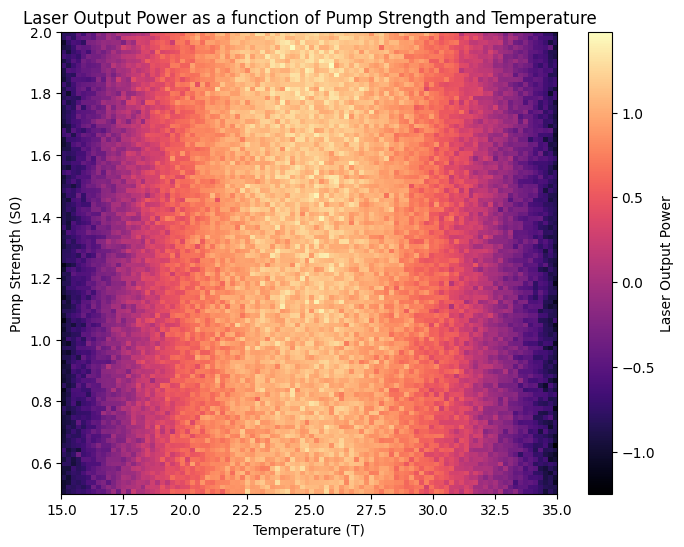

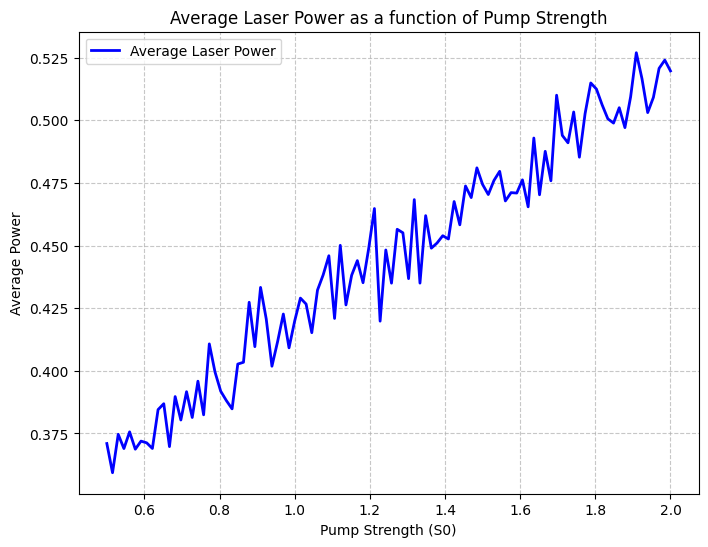

In [3]:
# Set up a grid of S_0 and T values
S0_values = np.linspace(0.5, 2.0, 100)  # Pump strength range
T_values = np.linspace(15, 35, 100)      # Temperature range

# Initialize a 2D array to store the power values
power_values = np.zeros((len(S0_values), len(T_values)))

# Simulate power for each combination of S_0 and T
for i, S0 in enumerate(S0_values):
    for j, T in enumerate(T_values):
        power_values[i, j] = laser_power(S0, T)

# Plot the heatmap of power as a function of S_0 and T
plt.figure(figsize=(8, 6))
plt.imshow(power_values, extent=[T_values.min(), T_values.max(), 
                                 S0_values.min(), S0_values.max()],
           origin='lower', aspect='auto', cmap='magma')
plt.colorbar(label='Laser Output Power')
plt.xlabel('Temperature (T)')
plt.ylabel('Pump Strength (S0)')
plt.title('Laser Output Power as a function of Pump Strength and Temperature')
plt.show()

# Now, let's plot the average intensity of laser power as a line plot
average_power = np.mean(power_values, axis=1)  # Average across temperature values

plt.figure(figsize=(8, 6))
plt.plot(S0_values, average_power, 'b-', lw=2, label='Average Laser Power')
plt.xlabel('Pump Strength (S0)')
plt.ylabel('Average Power')
plt.title('Average Laser Power as a function of Pump Strength')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper left')
plt.show()

##### Exercise 1.1: Add a line plot for laser power vs pump strength at optimal T.

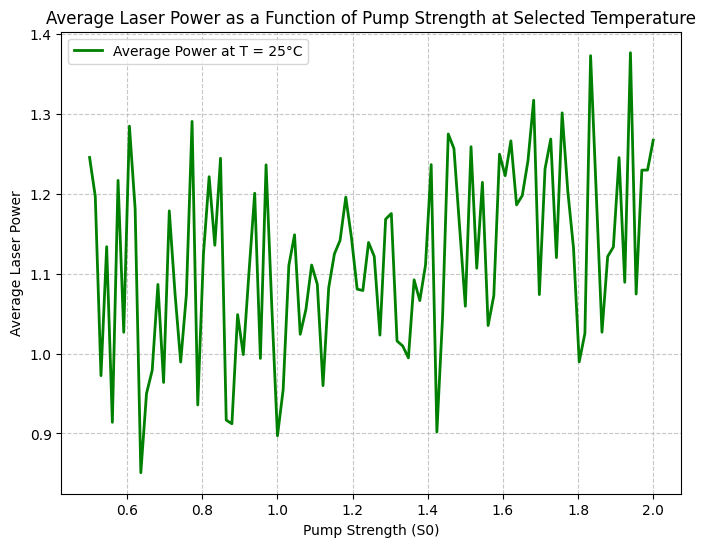

In [4]:
###### Solution 1.1
S0_grid, T_grid = np.meshgrid(S0_values, T_values)

# Calculate the mean laser power for each (S_0, T) combination
mean_power_values = np.zeros_like(S0_grid)

for i in range(S0_grid.shape[0]):
    for j in range(S0_grid.shape[1]):
        mean_power_values[i, j] = laser_power(S0_grid[i, j], T_grid[i, j])

# Select a specific temperature for the lineout
selected_temperature = 25  # Optimal temperature for the lineout

# Get the corresponding pump strength values and average power at that temperature
average_power_at_selected_temp = [laser_power(S0, selected_temperature) for S0 in S0_values]

# Plot the lineout of pump strength vs average laser power at the selected temperature
plt.figure(figsize=(8, 6))
plt.plot(S0_values, average_power_at_selected_temp, 'g-', lw=2, label=f'Average Power at T = {selected_temperature}°C')
plt.xlabel('Pump Strength (S0)')
plt.ylabel('Average Laser Power')
plt.title('Average Laser Power as a Function of Pump Strength at Selected Temperature')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper left')
plt.show()

##### Exercise 1.2: Add a line plot for laser power as a function of temperature at fixed S0

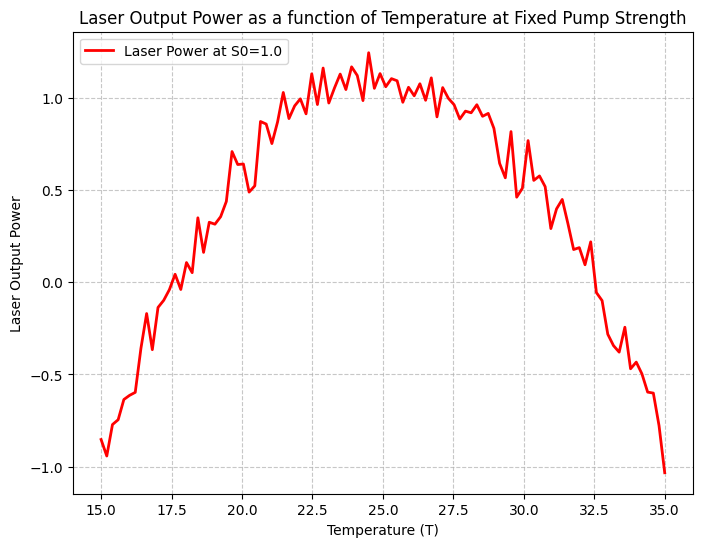

In [5]:
# Set up a fixed pump strength value
fixed_S0 = 1.0  # Fixed pump strength for this plot

# Set up a range of temperature values
T_values = np.linspace(15, 35, 100)  # Temperature range

# Simulate power for each temperature value
power_values_temp = np.array([laser_power(fixed_S0, T) for T in T_values])

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(T_values, power_values_temp, 'r-', lw=2, label='Laser Power at S0=1.0')
plt.xlabel('Temperature (T)')
plt.ylabel('Laser Output Power')
plt.title('Laser Output Power as a function of Temperature at Fixed Pump Strength')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper left')
plt.show()

#### Step 2: Define the Objective Function

In [6]:
def objective_function(S0, T, noise_level=0.1):
    """
    Laser power objective function.
    
    Args:
        S0: Pump strength.
        T: Temperature.
        noise_level: Level of Gaussian noise added to simulate fluctuations.

    Returns:
        Laser power for given S0 and T.
    """
    # Note: Ensure S0 is a 1D array for processing
    S0 = S0.reshape(-1)
    # Calculate the laser power using the laser power function
    power = laser_power(S0, T, noise_level=noise_level)
    return power

In [7]:
from bo_utils import *
from plotting_utils import *

#### Step 3: Make the Bayesian Optimization Loop

Initial Y_init shape: (2,)
Iteration 1: S0_next = 95.74646998971363, Power = 10.511108764051803


NameError: name 'Y' is not defined

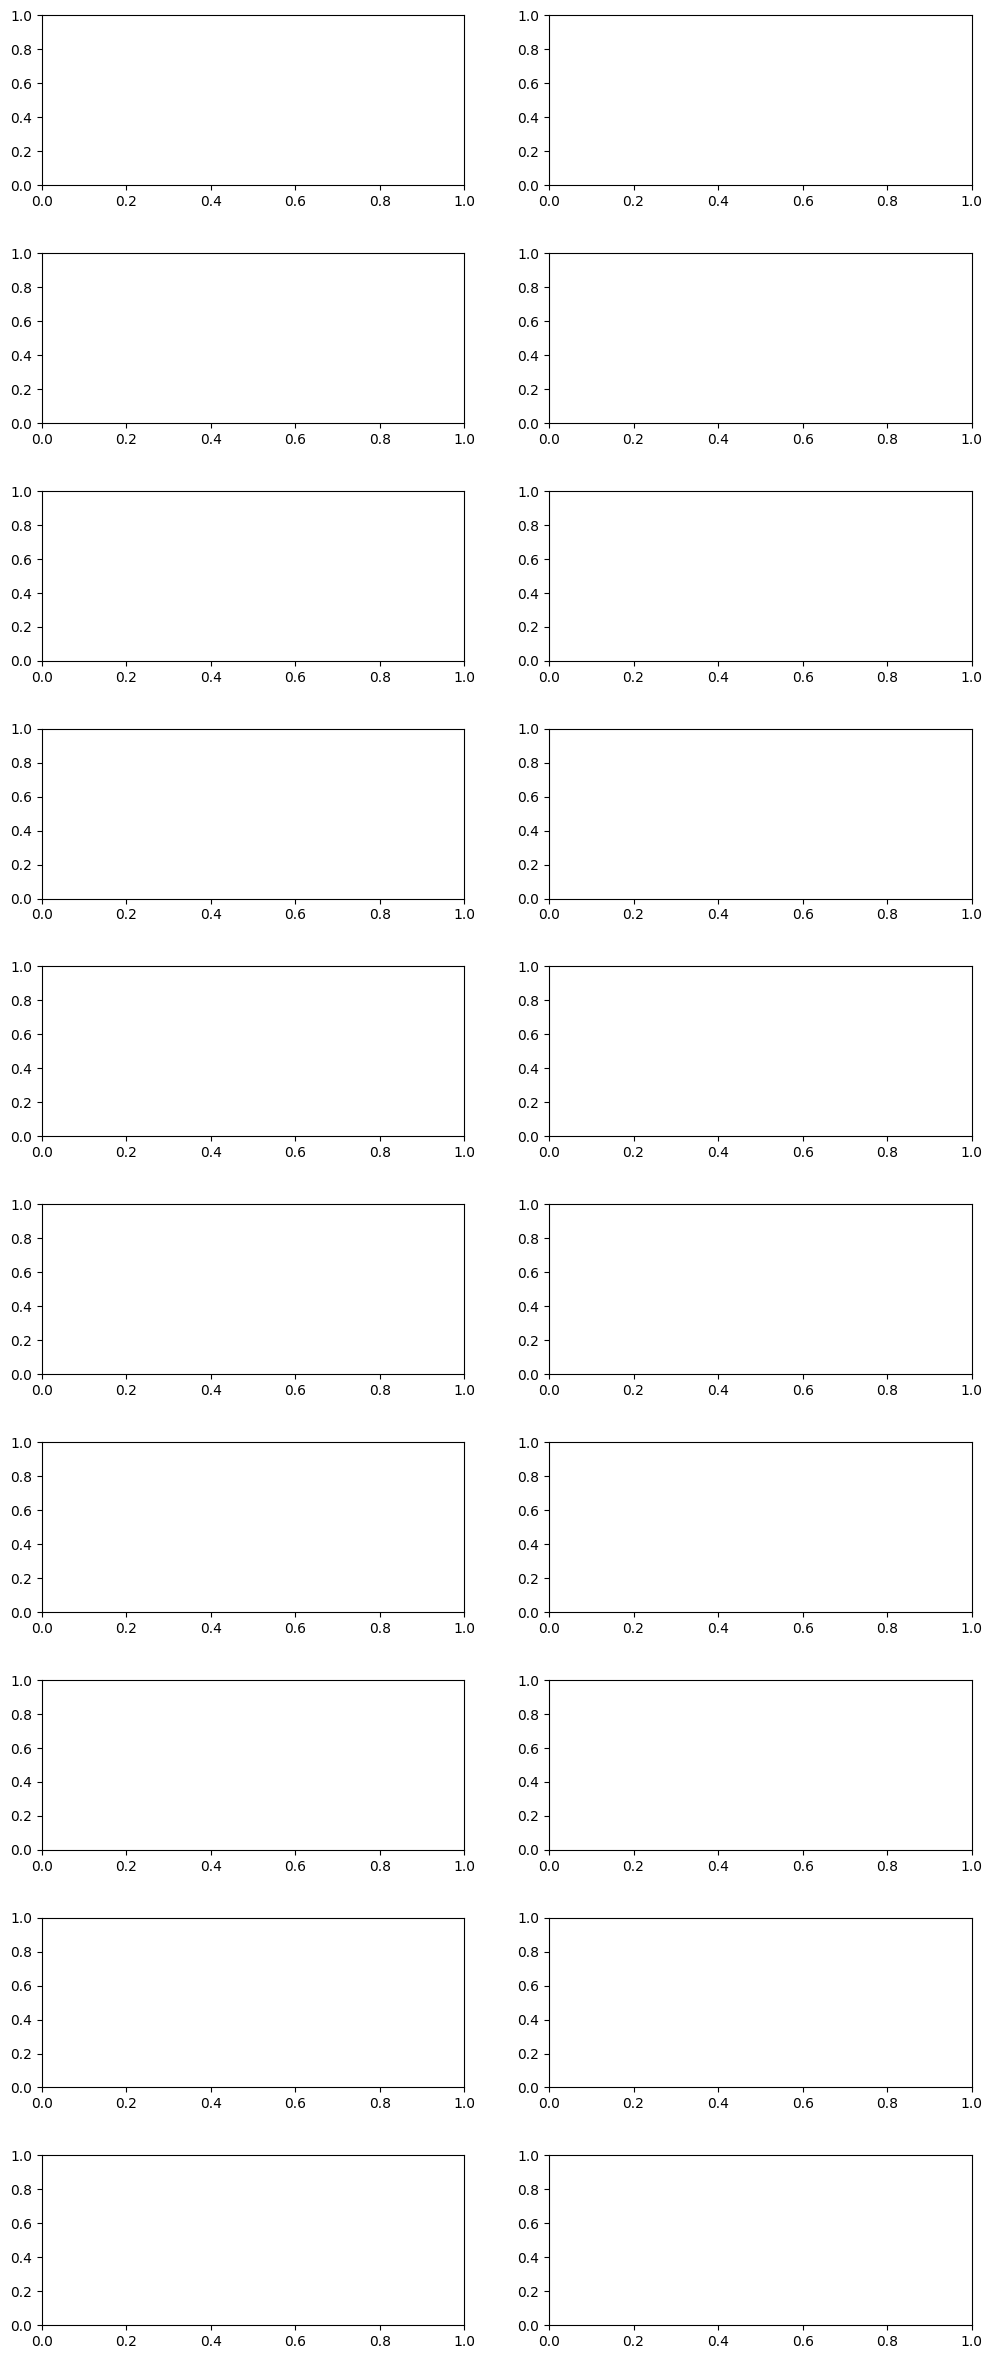

In [8]:
# Parameters for Bayesian optimization
n_iter = 10
n_init = 2 
n_points = 100
bounds = np.array([[0, n_points]])  # Define bounds for pump strength (e.g., 0 to 100)
noise_level = 0.05

# Initialize training data
S0_init = np.random.uniform(bounds[0, 0], bounds[0, 1], size=(n_init, 1))  # Random initial pump strengths
T_init = 25  # Set a fixed temperature for initial exploration
Y_init = objective_function(S0_init, T_init, noise_level=noise_level)  # Get initial laser power values
print("Initial Y_init shape:", Y_init.shape)  # Check shape

gp = GaussianProcessRegressor(kernel=RBF(), n_restarts_optimizer=10)

# Prepare for plotting
X = np.linspace(bounds[0, 0], bounds[0, 1], 100).reshape(-1, 1)
fig, axes = plt.subplots(n_iter, 2, figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)


for i in range(n_iter):
    gp.fit(S0_init, Y_init)
    
    # Suggest the next sampling point using the acquisition function
    S0_next = suggest_next_sample(expected_improvement, S0_init, Y_init, gp, bounds)
    
    # Obtain the next sample from the objective function
    Y_next = objective_function(S0_next, T_init, noise_level=noise_level)
    print(f"Iteration {i + 1}: S0_next = {S0_next.flatten()[0]}, Power = {Y_next.flatten()[0]}")
    
    # Reshape Y_init and Y_next if necessary
    if Y_init.ndim == 1:
        Y_init = Y_init.reshape(-1, 1)  # Ensure Y_init is a column vector
    Y_next = Y_next.reshape(-1, 1)  # Ensure Y_next is a column vector

    # Update the training data
    S0_init = np.vstack((S0_init, S0_next))
    Y_init = np.vstack((Y_init, Y_next))

    # Plot the GP approximation, noisy samples, and the next sampling point
    plot_prediction(axes[i, 0], gp, X, Y, S0_init, Y_init, S0_next, noise_level=noise_level, show_legend=(i == 0))
    axes[i, 0].set_title(f'Iteration {i + 1}')

    # Plot the acquisition (utility) function and the proposed next sample
    ei_values = expected_improvement(X, S0_init, Y_init, gp)
    plot_utility(axes[i, 1], X, ei_values, S0_next, show_legend=(i == 0))

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))  # Create subplots
plot_convergence(ax, S0_init.ravel(), Y_init.ravel(), n_init=n_init, show_legend=True)
plt.show()  # Display the plots